In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

In [147]:
df = pd.read_csv('./datasets/gym_churn.csv')

**Target Variable:**
- `Churn` — whether the client churned in the current month (1 = churned, 0 = retained).

**Client Information (from the prior month):**
- `gender` — client’s gender.
- `Near_Location` — lives or works near the gym.
- `Partner` — employee of a partner company (eligible for subscription discounts).
- `Promo_friends` — membership purchased through a referral campaign.
- `Phone` — phone number provided.
- `Age` — client’s age.
- `Lifetime` — time since first visit (in months).

**Activity History and Subscription Details:**
- `Contract_period` — duration of the current contract (1, 3, 6, or 12 months).
- `Month_to_end_contract` — months remaining on the current contract.
- `Group_visits` — participation in group classes.
- `Avg_class_frequency_total` — average weekly visits since the contract start.
- `Avg_class_frequency_current_month` — average weekly visits in the last month.
- `Avg_additional_charges_total` — total revenue from additional services (e.g., cafe, sports goods, spa).

In [148]:
plt.style.use('ggplot')
sns.set_style('white')
sns.set_palette('pastel')

## 1. Exploratory Data Analysis (EDA)

In [149]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [151]:
df.duplicated().sum()

np.int64(0)

In [152]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


We see that some of our variables have a significantly wider range between their minimum and maximum values compared to others. Therefore, it would be beneficial to standardize these variables before applying machine learning models.

Let's look at the averages by grouping the dataframe by the Churn column

In [153]:
churn_info = pd.DataFrame({
    'Mean (Churned)': df.query('Churn != 0').mean(),
    'Mean (Not Churned)': df.query('Churn == 0').mean()
})

In [154]:
churn_info

,Mean (Churned),Mean (Not Churned)
gender,0.510839,0.510037
Near_Location,0.768143,0.873086
Partner,0.355325,0.534195
Promo_friends,0.183789,0.353522
Phone,0.902922,0.903709
Contract_period,1.728558,5.747193
Group_visits,0.268615,0.464103
Age,26.989632,29.976523
Avg_additional_charges_total,115.082899,158.445715
Month_to_end_contract,1.662582,5.283089


The key features show that, in general, customers in churn have less activity, lower additional costs and shorter duration of the current active subscription.

Let's Build histograms and trait distributions for those who left (churn) and those who stayed (didn't hit the churn)

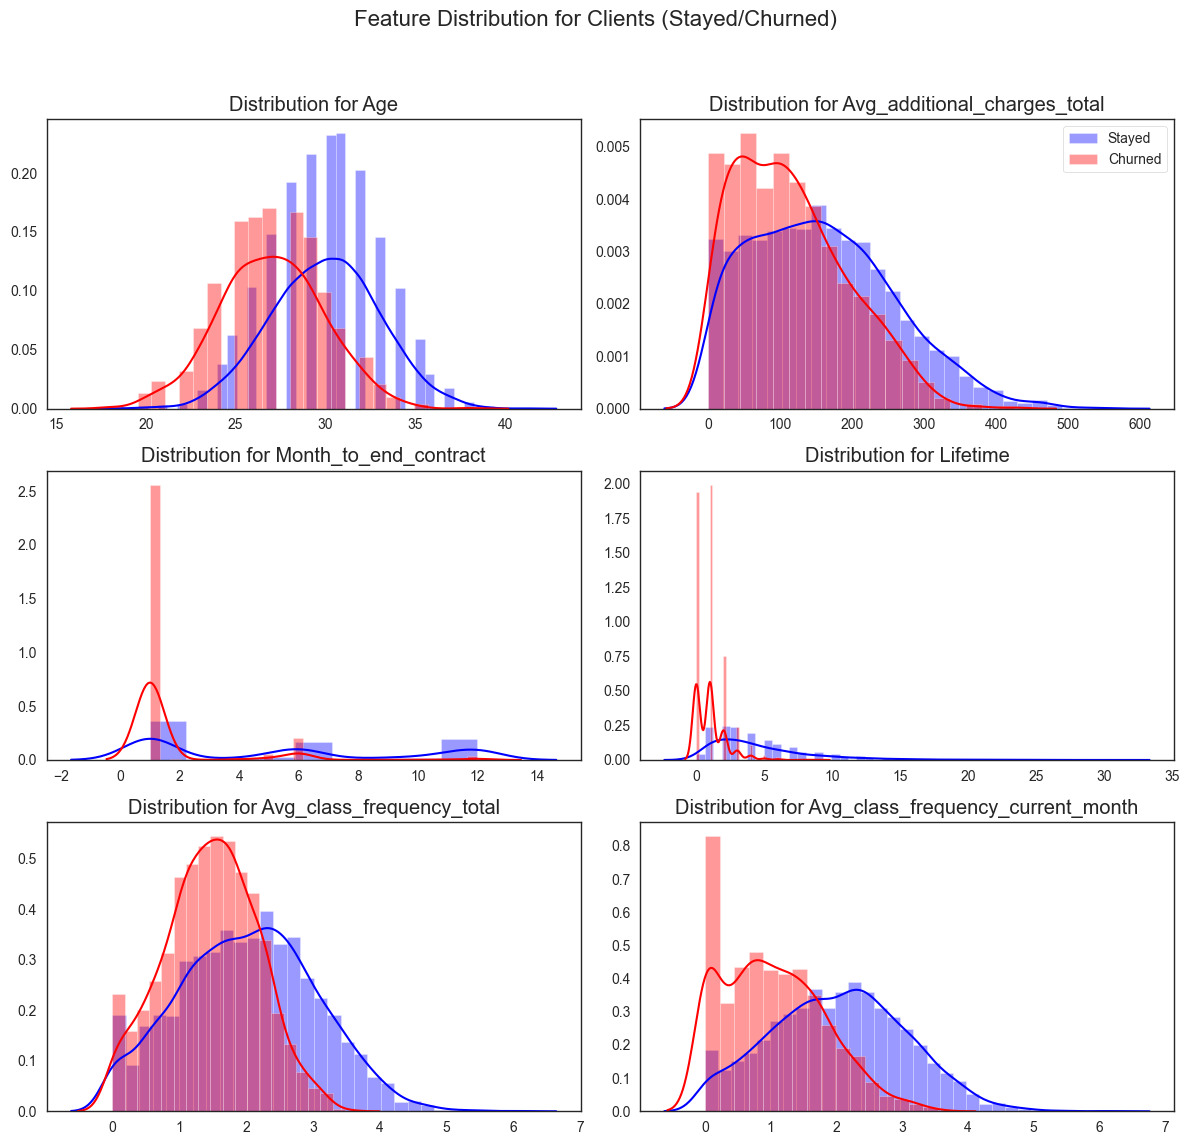

In [155]:
num_features = df.drop(columns=['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
                                'Group_visits', 'Contract_period', 'Churn']).columns

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Feature Distribution for Clients (Stayed/Churned)', fontsize=16)
axes = axes.flatten()

# Plot each feature's distribution
for i, col in enumerate(num_features):
    sns.distplot(df.query('Churn == 0')[col], ax=axes[i], label='Stayed', color='blue')
    sns.distplot(df.query('Churn != 0')[col], ax=axes[i], label='Churned', color='red')
    axes[i].set_title(f'Distribution for {col}')
    axes[i].legend() if i == 1 else None
    axes[i].grid(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* Young people leave more often than adults
* Customers who leave spend less
* Churn customers mostly buy a one-month membership.
* Only newcomers leave, if a client has been in the gym for more than 5 months, his leaving is almost zero.
* Clients in the churn most often visit the gym from 1 to 2 times a week.
* If a client has not visited the gym once in a month, then most likely he will not come back, if he has visited the gym more than 4 times, then most likely he will become a regular client.

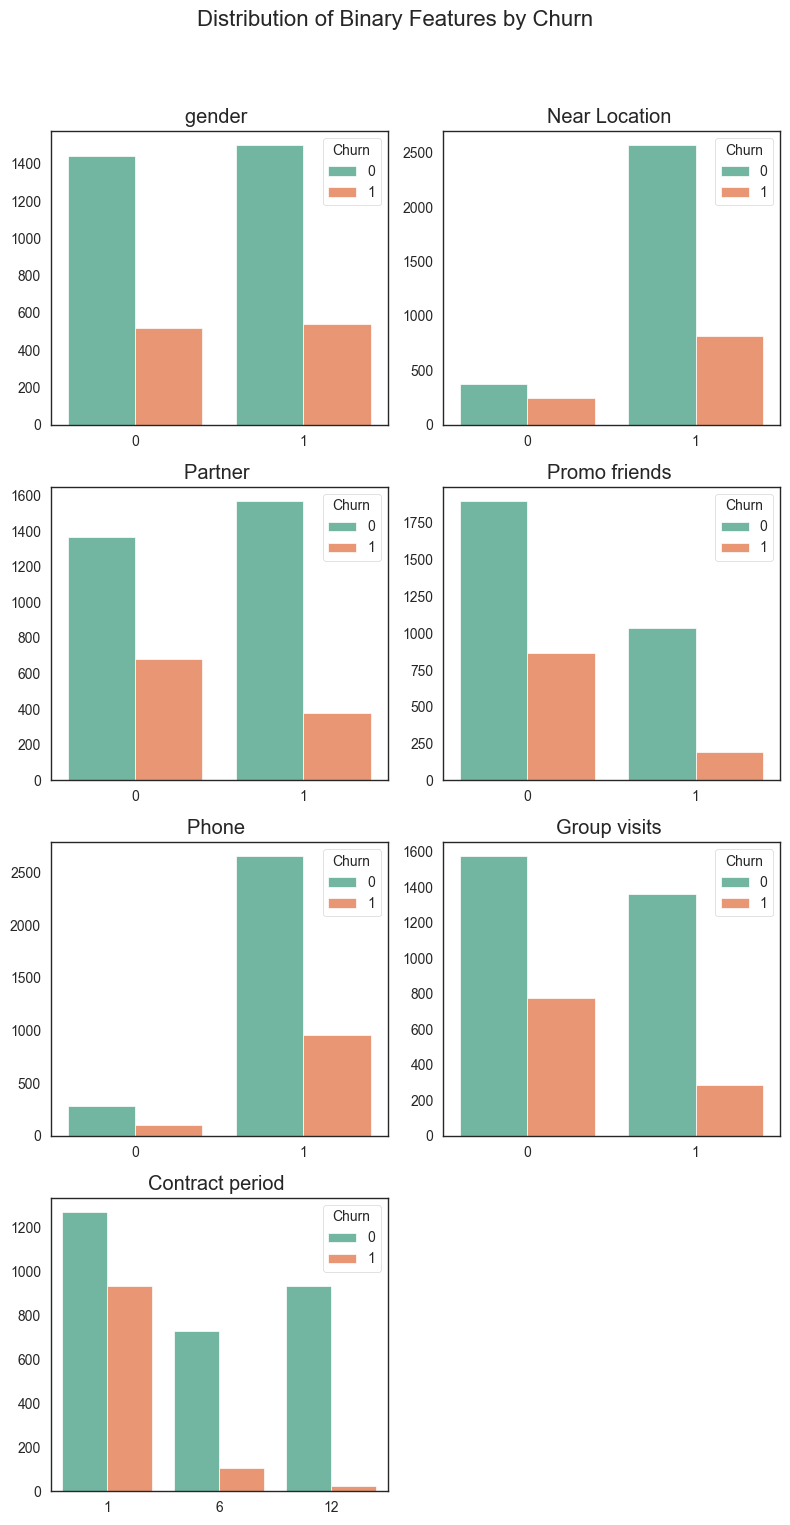

In [156]:
binar_feat = df[['gender', 'Near_Location', 'Partner', 'Promo_friends', 
                 'Phone', 'Group_visits', 'Contract_period', 'Churn']]

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
fig.suptitle('Distribution of Binary Features by Churn', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(binar_feat.columns[:-1]):
    sns.countplot(x=col, hue='Churn', data=binar_feat, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{' '.join(col.split('_'))} ')
    axes[i].legend(title='Churn', loc='upper right')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('') 

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We see that customers who leave more often:

* Buy a subscription for one month only
* Attend group classes less often

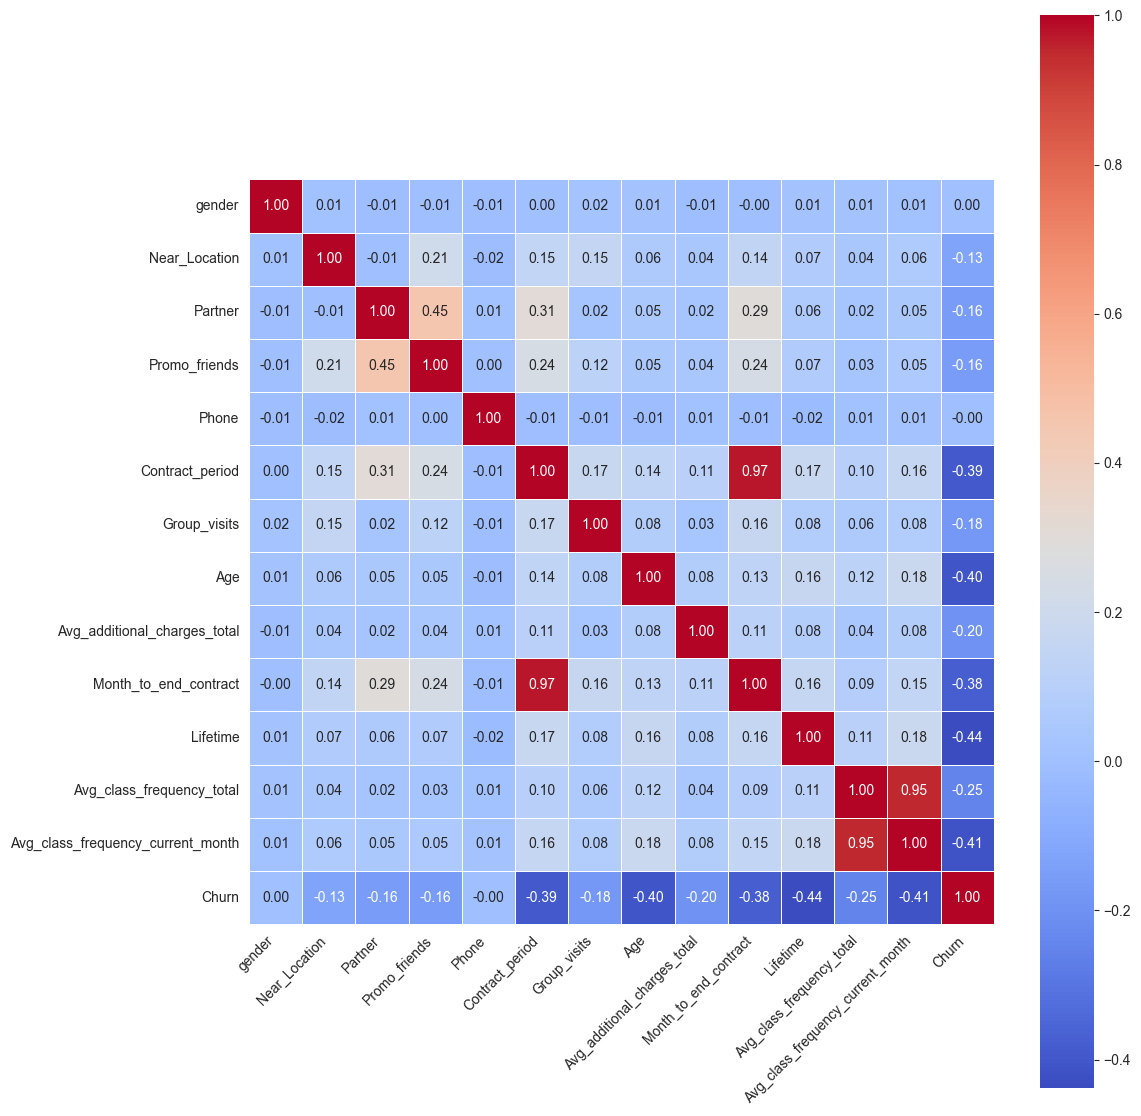

In [157]:
cm = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

We can see that such attributes as Month_to_end_contract and Contract_period = 0.97, as well as Avg_class_frequency_current_month and Avg_class_frequency_total = 0.95 are strongly correlated, which is logical since the attributes are related. There is also a dependence between Promo_friends and Partner, it can be assumed that employees of the partner company invite their friends more often than usual.

## 2. Customer churn predictive model

In [158]:
X = df.drop('Churn', axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [159]:
def display_metrics(y_true, y_pred, y_proba=None, title='Classification Metrics'):

    print(title)
    print(f'\tAccuracy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'\tPrecision: {precision_score(y_true, y_pred):.2f}')
    print(f'\tRecall: {recall_score(y_true, y_pred):.2f}')
    print(f'\tF1 Score: {f1_score(y_true, y_pred):.2f}')
    
    if y_proba is not None:
        print(f'\tROC AUC: {roc_auc_score(y_true, y_proba):.2f}')

In [160]:
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]

display_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for the logistic regression model:')

Metrics for the logistic regression model:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.81
	F1 Score: 0.84
	ROC AUC: 0.97


In [161]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

display_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for the random forrest:')

Metrics for the random forrest:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1 Score: 0.85
	ROC AUC: 0.97


In general, the models do not differ critically, but the random forest model performed better than the logistic regression model. Also the quality of both models is very high - 0.97 by ROC_AUC.

Consider the importance of feature under both models

In [162]:
log_reg = pd.DataFrame({'feature' : X_train.columns, 'coef' : lr_model.coef_[0]})
log_reg.sort_values(by='coef', ascending=True)

,feature,coef
12,Avg_class_frequency_current_month,-4.938758
10,Lifetime,-0.926255
6,Group_visits,-0.354837
3,Promo_friends,-0.256250
9,Month_to_end_contract,-0.205876
1,Near_Location,-0.123368
7,Age,-0.108286
5,Contract_period,-0.085909
8,Avg_additional_charges_total,-0.004399
2,Partner,0.203887


Let's get rid of the highly correlated features that we found earlier using the correlation map so that the coefficient values are more intuitive to understand

In [163]:
lr_model_test = LogisticRegression(random_state = 0)
X_train_cleared = X_train.drop(['Avg_class_frequency_current_month', 'Month_to_end_contract'], axis=1)
lr_model_test.fit(X_train_cleared, y_train)

log_reg = pd.DataFrame({'feature' : X_train_cleared.columns, 'coef' : lr_model_test.coef_[0]})
log_reg.sort_values(by='coef', ascending=True)

,feature,coef
9,Lifetime,-1.008255
10,Avg_class_frequency_total,-0.784570
3,Promo_friends,-0.526608
6,Group_visits,-0.299442
5,Contract_period,-0.295943
7,Age,-0.290917
1,Near_Location,-0.267057
0,gender,-0.066136
8,Avg_additional_charges_total,-0.005165
2,Partner,0.367909


In [164]:
f_m = pd.DataFrame({'feature' : X_train.columns, 'importance' : rf_model.feature_importances_})
f_m.sort_values(by='importance', ascending=False)

,feature,importance
10,Lifetime,0.270348
12,Avg_class_frequency_current_month,0.176243
11,Avg_class_frequency_total,0.136423
7,Age,0.121275
8,Avg_additional_charges_total,0.088192
9,Month_to_end_contract,0.072685
5,Contract_period,0.067406
6,Group_visits,0.016091
0,gender,0.012279
2,Partner,0.012097


Since we have chosen the Random Forest model based on the values of the metrics, We will be guided by it to formulate the conclusion

## 3. Кластеризацию клиентов

In [168]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

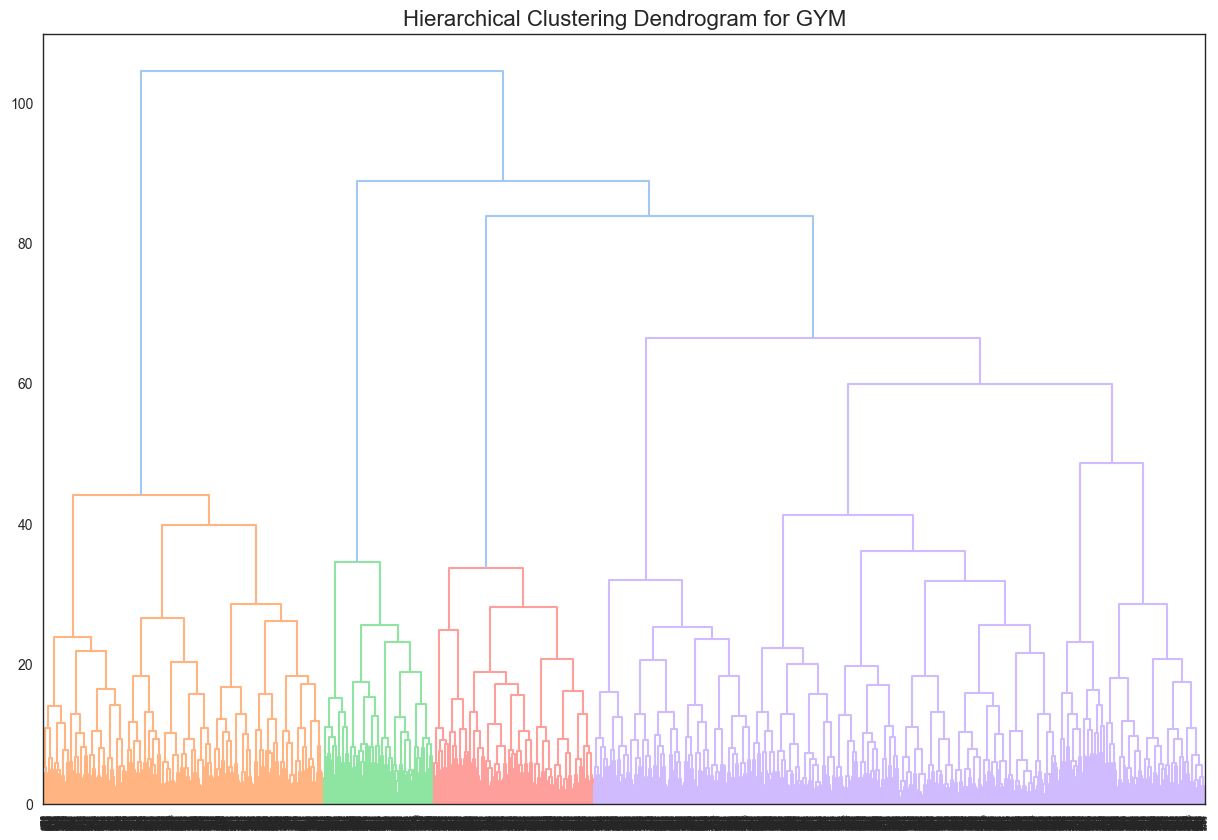

In [173]:
linked = linkage(x_sc, method='ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchical Clustering Dendrogram for GYM', fontsize=16)

plt.show()

In [175]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)
df_clust_1 = df
df_clust_1['cluster_km'] = labels

In [180]:
df_clust_final = df_clust_1.copy(deep=True)
df_clust_grouped_mean = df_clust_final.groupby('cluster_km').agg('mean')
df_clust_grouped_mean

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.486819,1.000000,0.243409,0.007030,0.899824,1.978910,0.326889,28.239016,130.877033,1.896309,2.477153,1.318003,1.083831,0.513181
1,0.592493,0.970509,0.288204,0.123324,0.898123,2.898123,0.482574,30.339142,164.193829,2.654155,5.219839,2.937411,2.944131,0.054960
2,0.499469,0.943677,0.740701,0.489904,0.900106,11.866100,0.551541,29.905420,165.146492,10.852285,4.737513,1.989423,1.980764,0.022317
3,0.483360,1.000000,0.798732,1.000000,0.911252,3.079239,0.445325,29.052298,139.858265,2.873217,3.510301,1.665722,1.547717,0.269414
4,0.496324,0.000000,0.466912,0.077206,0.915441,2.209559,0.215074,28.483456,133.630215,2.073529,2.781250,1.657657,1.466870,0.450368


The highest churn rate is in the 0th cluster - 51.3%, in the 3rd and 4th clusters - 45.0% and 26.9%, the minimum values are in the 1st and 2nd clusters - 5.4% and 2.2% (we will consider them reliable).

In [182]:
# Выделение бинарных и небинарных признаков
binary_cols = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 
               'Group_visits', 'Contract_period', 'Month_to_end_contract', 'Lifetime']

binary = df[binary_cols]
non_binary = df.drop(columns=binary_cols + ['Churn', 'cluster_km'])

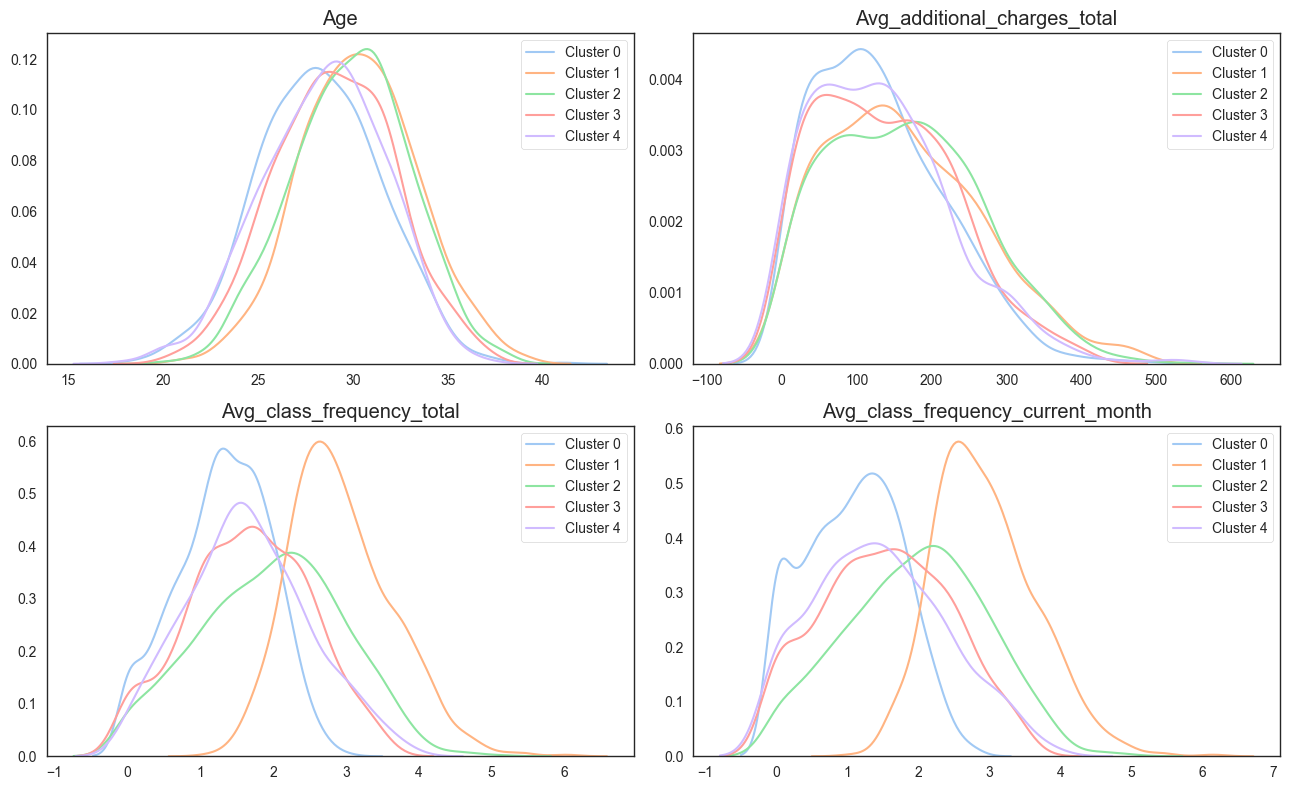

In [191]:
# Создаем фигуру и подграфики
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.flatten()

for idx, col in enumerate(non_binary.columns):
    ax = axes[idx]
    for i in range(5):
        sns.kdeplot(df_clust_1.query('cluster_km == @i')[col], ax=ax, label=f'Cluster {i}')
        
    ax.set_title(col)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

- The **Age** chart shows that younger clients are most likely to churn, peaking at age 28 (Cluster 0), while more reliable clusters have older members: Cluster 2 peaks at age 32, and Cluster 4 at age 30.
- For **Additional Charges**, reliable clusters have wider distributions, while most clients in Cluster 0 spend less, followed by Clusters 4 and 3.
- **Activity Level**: Cluster 1 is the most active, averaging 3 visits per week, while Cluster 0 has the lowest activity, averaging 1 visit per week. Higher weekly attendance generally indicates lower churn likelihood.
- **Monthly Attendance** trends largely mirror weekly attendance patterns.

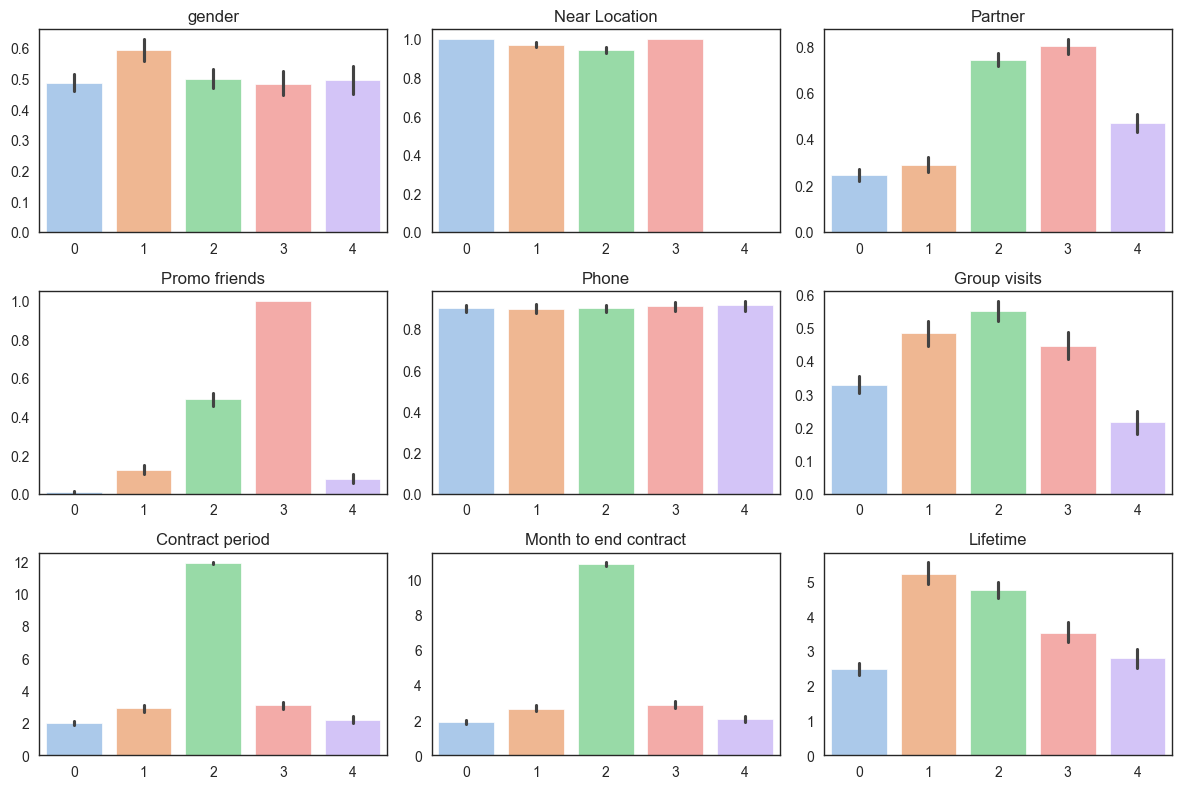

In [201]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    x = df_clust_1['cluster_km']
    y = binary.iloc[:, i]
    sns.barplot(x=x, y=y, ax=ax, palette="pastel")
    
    ax.set_title(' '.join(binary.columns[i].split('_')), fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x')

plt.tight_layout()
plt.show()

* The **Lifetime** trend (time since first visit) shows that new clients are the most likely to churn.
* The **Contract Period** trend is interesting; cluster 0 and 4 has a significantly shorter contract duration, possibly because clients prefer shorter contracts. This might be price-related, as cluster 2 mainly has annual memberships with an average of 10.8 months. The **Partner** feature also shows notable dynamics, to be mentioned in the conclusion.
* **Cluster 0** hasn't been promoted by friends.
* **Cluster 4** clients live/work far from the gym.
* **Cluster 2** clients are the most active in group classes, likely due to high **Partner** and **Promo_friends** rates, indicating many have friends who attend, reinforcing their loyalty.